In [1]:
!pip install -q dm-sonnet

In [2]:
import numpy as np
import tqdm as tqdm
import sklearn.datasets as skd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde

# tf and friends
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
import sonnet as snt
tf.enable_v2_behavior()

tfb = tfp.bijectors
tfd = tfp.distributions

def make_grid(xmin, xmax, ymin, ymax, gridlines, pts):
  xpts = np.linspace(xmin, xmax, pts)
  ypts = np.linspace(ymin, ymax, pts)
  xgrid = np.linspace(xmin, xmax, gridlines)
  ygrid = np.linspace(ymin, ymax, gridlines)
  xlines = np.stack([a.ravel() for a in np.meshgrid(xpts, ygrid)])
  ylines = np.stack([a.ravel() for a in np.meshgrid(xgrid, ypts)])
  return np.concatenate([xlines, ylines], 1).T

grid = make_grid(-3, 3, -3, 3, 4, 100)

In [3]:
import numpy as np
import sklearn
import sklearn.datasets
from sklearn.utils import shuffle as util_shuffle


# Dataset iterator
def inf_train_gen(data, rng=None, batch_size=200):
    if rng is None:
        rng = np.random.RandomState()

    if data == "8gaussians":
        scale = 4.
        centers = [(1, 0), (-1, 0), (0, 1), (0, -1), (1. / np.sqrt(2), 1. / np.sqrt(2)),
                   (1. / np.sqrt(2), -1. / np.sqrt(2)), (-1. / np.sqrt(2),
                                                         1. / np.sqrt(2)), (-1. / np.sqrt(2), -1. / np.sqrt(2))]
        centers = [(scale * x, scale * y) for x, y in centers]

        dataset = []
        for i in range(batch_size):
            point = rng.randn(2) * 0.5
            idx = rng.randint(8)
            center = centers[idx]
            point[0] += center[0]
            point[1] += center[1]
            dataset.append(point)
        dataset = np.array(dataset, dtype="float32")
        dataset /= 1.414
        return dataset


    elif data == "checkerboard":
        x1 = np.random.rand(batch_size) * 4 - 2
        x2_ = np.random.rand(batch_size) - np.random.randint(0, 2, batch_size) * 2
        x2 = x2_ + (np.floor(x1) % 2)
        return np.concatenate([x1[:, None], x2[:, None]], 1) * 2

In [4]:
base_loc = np.array([0.0, 0.0]).astype(np.float32)
base_sigma = np.array([0.8, 0.8]).astype(np.float32)
base_distribution = tfd.MultivariateNormalDiag(base_loc, base_sigma)
class MLP_ODE(snt.Module):
  """Multi-layer NN ode_fn."""
  def __init__(self, num_hidden, num_layers, num_output, name='mlp_ode'):
    super(MLP_ODE, self).__init__(name=name)
    self._num_hidden = num_hidden
    self._num_output = num_output
    self._num_layers = num_layers
    self._modules = []
    for _ in range(self._num_layers - 1):
      self._modules.append(snt.Linear(self._num_hidden))
      self._modules.append(tf.math.tanh)
    self._modules.append(snt.Linear(self._num_output))
    self._model = snt.Sequential(self._modules)

  def __call__(self, t, inputs):
    inputs = tf.concat([tf.broadcast_to(t, inputs.shape), inputs], -1)
    return self._model(inputs)

In [5]:
def plot_density(data, axis):
  x, y = np.squeeze(np.split(data, 2, axis=1))
  levels = np.linspace(0.0, 0.75, 10)
  kwargs = {'levels': levels}
  return sns.kdeplot(x, y, cmap="viridis", shade=True, 
                     shade_lowest=True, ax=axis, **kwargs)


def plot_points(data, axis, s=100, color='b', label=''):
  x, y = np.squeeze(np.split(data, 2, axis=1))
  axis.scatter(x, y, c=color, s=s, label=label)


def plot_panel(
    grid, samples, transformed_grid, transformed_samples,
    dataset, axarray, limits=True):
  if len(axarray) != 4:
    raise ValueError('Expected 4 axes for the panel')
  ax1, ax2, ax3, ax4 = axarray
  plot_points(data=grid, axis=ax1, s=20, color='black', label='grid')
  plot_points(samples, ax1, s=30, color='blue', label='samples')
  plot_points(transformed_grid, ax2, s=20, color='black', label='ode(grid)')
  plot_points(transformed_samples, ax2, s=30, color='blue', label='ode(samples)')
  ax3 = plot_density(transformed_samples, ax3)
  ax4 = plot_density(dataset, ax4)
  if limits:
    set_limits([ax1], -3.0, 3.0, -3.0, 3.0)
    set_limits([ax2], -2.0, 3.0, -2.0, 3.0)
    set_limits([ax3, ax4], -1.5, 0.5, -0.75, 1.25)


def set_limits(axes, min_x, max_x, min_y, max_y):
  if isinstance(axes, list):
    for axis in axes:
      set_limits(axis, min_x, max_x, min_y, max_y)
  else:
    axes.set_xlim(min_x, max_x)
    axes.set_ylim(min_y, max_y)

In [6]:
#@title Model and training parameters
LR = 1e-2  #@param
NUM_EPOCHS = 80  #@param
STACKED_FFJORDS = 4  #@param
NUM_HIDDEN = 8  #@param
NUM_LAYERS = 3  #@param
NUM_OUTPUT = 2

In [7]:
#@title Building bijector
solver = tfp.math.ode.DormandPrince(atol=1e-5)
ode_solve_fn = solver.solve
trace_augmentation_fn = tfb.ffjord.trace_jacobian_exact

bijectors = []
for _ in range(STACKED_FFJORDS):
  mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT)
  next_ffjord = tfb.FFJORD(
      state_time_derivative_fn=mlp_model,ode_solve_fn=ode_solve_fn,
      trace_augmentation_fn=trace_augmentation_fn)
  bijectors.append(next_ffjord)

stacked_ffjord = tfb.Chain(bijectors[::-1])

In [8]:
transformed_distribution = tfd.TransformedDistribution(
    distribution=base_distribution, bijector=stacked_ffjord)
#@title Training
@tf.function
def train_step(optimizer, target_sample):
  with tf.GradientTape() as tape:
    loss = -tf.reduce_mean(transformed_distribution.log_prob(target_sample))
  variables = tape.watched_variables()
  gradients = tape.gradient(loss, variables)
  optimizer.apply(gradients, variables)
  return loss
def train_step_g(optimizer, target_sample):
  with tf.GradientTape() as tape:
    loss = -tf.reduce_mean(transformed_distribution.log_prob(target_sample))
  variables = tape.watched_variables()
  gradients = tape.gradient(loss, variables)
  optimizer.apply(gradients, variables)
  return loss
#@title Samples
@tf.function
def get_samples():
  base_distribution_samples = base_distribution.sample(SAMPLE_SIZE)
  transformed_samples = transformed_distribution.sample(SAMPLE_SIZE)
  return base_distribution_samples, transformed_samples


@tf.function
def get_transformed_grid():
  transformed_grid = stacked_ffjord.forward(grid)
  return transformed_grid


In [9]:
DATASET_SIZE = 1024 * 8  #@param
BATCH_SIZE = 256  #@param
SAMPLE_SIZE = DATASET_SIZE
evaluation_samples = []
base_samples, transformed_samples = get_samples()
transformed_grid = get_transformed_grid()
evaluation_samples.append((base_samples, transformed_samples, transformed_grid))

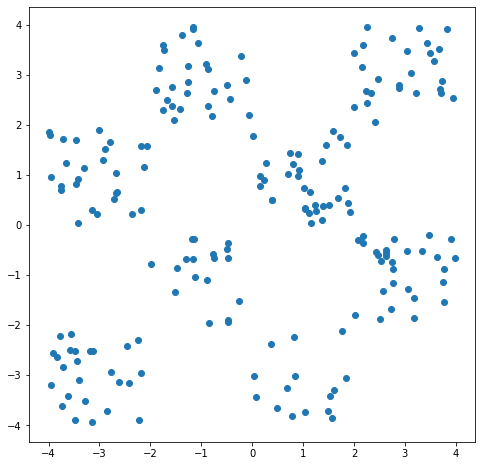

In [10]:

DATASET_SIZE = 1024 * 8  #@param
BATCH_SIZE = 256  #@param
SAMPLE_SIZE = DATASET_SIZE

#moons = skd.make_moons(n_samples=DATASET_SIZE, noise=.06)[0]
boards = inf_train_gen("checkerboard")
boards_ds = tf.data.Dataset.from_tensor_slices(boards.astype(np.float32))
boards_ds = boards_ds.prefetch(tf.data.experimental.AUTOTUNE)
boards_ds = boards_ds.cache()
boards_ds = boards_ds.shuffle(DATASET_SIZE)
boards_ds = boards_ds.batch(BATCH_SIZE)

plt.figure(figsize=[8, 8])
plt.plot(boards[:, 0], boards[:, 1],"o")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setti

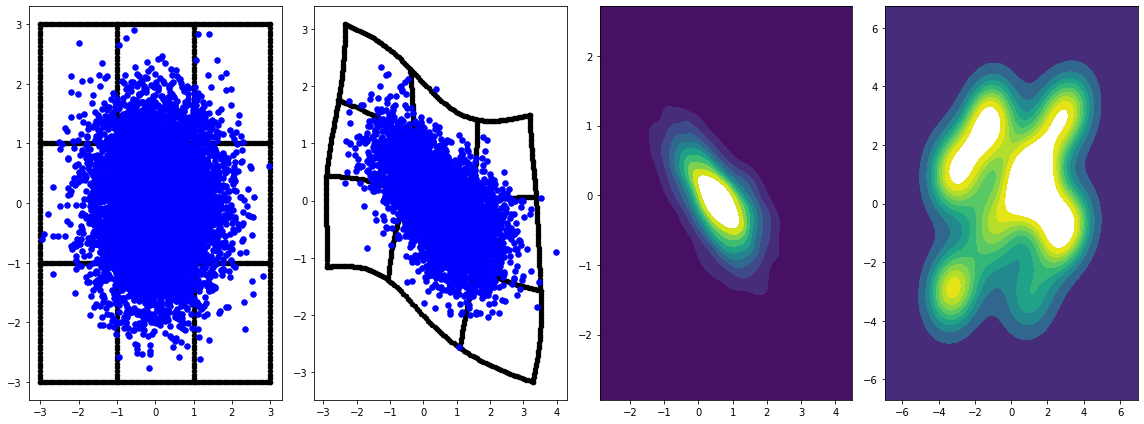

In [11]:
panel_id = 0
panel_data = evaluation_samples[panel_id]
fig, axarray = plt.subplots(1, 4, figsize=(16, 6))
plot_panel(grid, panel_data[0], panel_data[2], panel_data[1], boards, axarray, False)
plt.tight_layout()

In [12]:
learning_rate = tf.Variable(LR, trainable=False)
optimizer = snt.optimizers.Adam(learning_rate)

for epoch in tqdm.trange(NUM_EPOCHS // 2):
  base_samples, transformed_samples = get_samples()
  transformed_grid = get_transformed_grid()
  evaluation_samples.append(
      (base_samples, transformed_samples, transformed_grid))
for batch in boards_ds:
    _ = train_step(optimizer, batch)

100%|██████████| 40/40 [00:04<00:00,  8.69it/s]


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setti

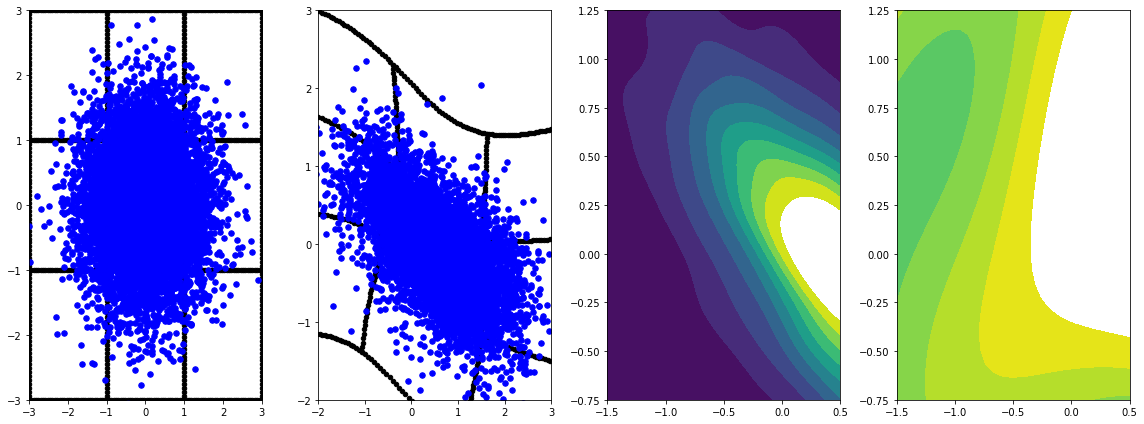

In [13]:
panel_id = -1
panel_data = evaluation_samples[panel_id]
fig, axarray = plt.subplots(
  1, 4, figsize=(16, 6))
plot_panel(grid, panel_data[0], panel_data[2], panel_data[1], boards, axarray)
plt.tight_layout()

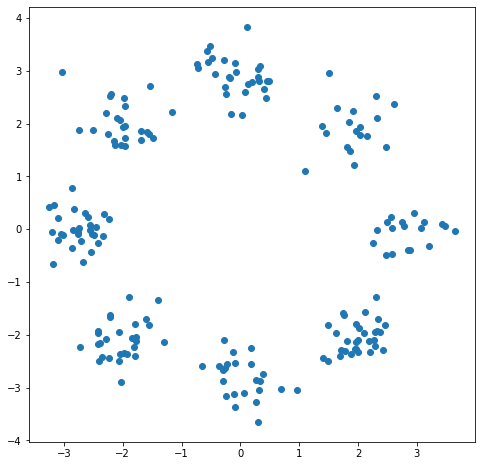

In [14]:
gaussians = inf_train_gen("8gaussians")
gaussians_ds = tf.data.Dataset.from_tensor_slices(gaussians.astype(np.float32))
gaussians_ds = gaussians_ds.prefetch(tf.data.experimental.AUTOTUNE)
gaussians_ds = gaussians_ds.cache()
gaussians_ds = gaussians_ds.shuffle(DATASET_SIZE)
gaussians_ds = gaussians_ds.batch(BATCH_SIZE)

plt.figure(figsize=[8, 8])
plt.plot(gaussians[:, 0], gaussians[:, 1],"o")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setti

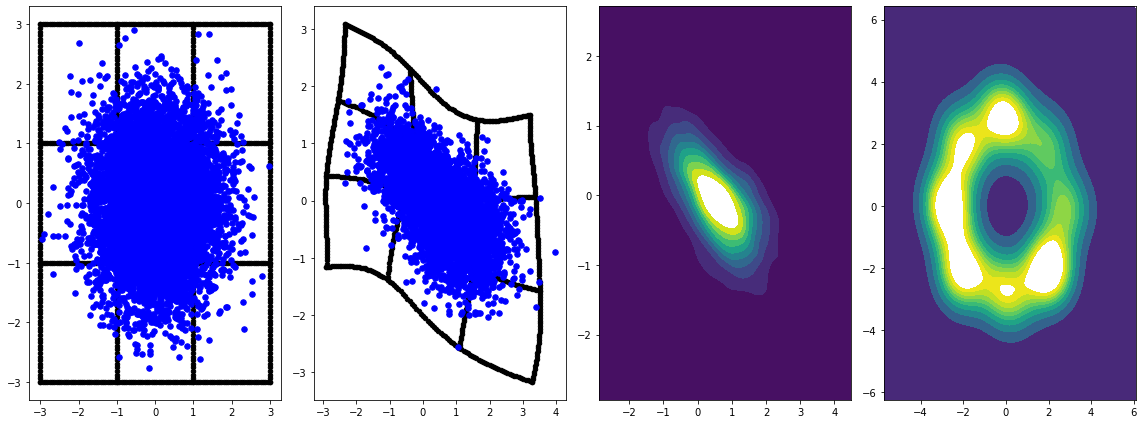

In [15]:
panel_id = 0
panel_data = evaluation_samples[panel_id]
fig, axarray = plt.subplots(1, 4, figsize=(16, 6))
plot_panel(grid, panel_data[0], panel_data[2], panel_data[1], gaussians, axarray, False)
plt.tight_layout()

In [16]:
learning_rate = tf.Variable(LR, trainable=False)
optimizer = snt.optimizers.Adam(learning_rate)

for epoch in tqdm.trange(NUM_EPOCHS // 2):
  base_samples, transformed_samples = get_samples()
  transformed_grid = get_transformed_grid()
  evaluation_samples.append(
      (base_samples, transformed_samples, transformed_grid))
for batch in gaussians_ds:
    _ = train_step_g(optimizer, batch)

100%|██████████| 40/40 [00:04<00:00,  8.61it/s]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setti

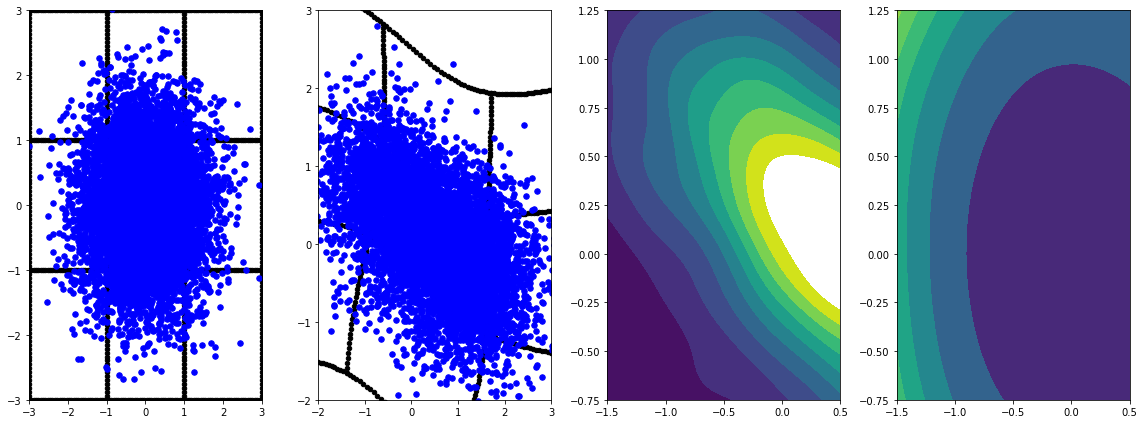

In [17]:
panel_id = -1
panel_data = evaluation_samples[panel_id]
fig, axarray = plt.subplots(
  1, 4, figsize=(16, 6))
plot_panel(grid, panel_data[0], panel_data[2], panel_data[1], gaussians, axarray)
plt.tight_layout()